In [1]:
# !pip install pytorch-ignite
# from google.colab import drive
# drive.flush_and_unmount()
# drive.mount('/content/drive')

In [2]:


import torch
from torch import nn

import matplotlib.pyplot as plt
import os

import numpy as np

from src.datasets.datasets import MovielensDataset
from src.models.mlstm import mLSTM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import datetime

# datetime object containing current date and time
script_start_time = datetime.datetime.now().strftime("%Y-%m-%d_%Hh%Mm%S")

find_lr = False

# model

In [3]:
# class ZeroEmbedding(nn.Embedding):
#     """
#     Embedding layer that initialises its values
#     to using a normal variable scaled by the inverse
#     of the embedding dimension.
#     Used for biases.
#     """

#     def reset_parameters(self):
#         """
#         Initialize parameters.
#         """

#         self.weight.data.zero_()
#         if self.padding_idx is not None:
#             self.weight.data[self.padding_idx].fill_(0)


class ScaledEmbedding(nn.Embedding):
    """
    Embedding layer that initialises its values
    to using a normal variable scaled by the inverse
    of the embedding dimension.
    """

    def reset_parameters(self):
        """
        Initialize parameters.
        """

        self.weight.data.normal_(0, 1.0 / self.embedding_dim)
        if self.padding_idx is not None:
            self.weight.data[self.padding_idx].fill_(0)

In [4]:
PADDING_IDX = 0
class mLSTMNet(nn.Module):
    """
    Module representing users through running a recurrent neural network
    over the sequence, using the hidden state at each timestep as the
    sequence representation, a'la [2]_
    During training, representations for all timesteps of the sequence are
    computed in one go. Loss functions using the outputs will therefore
    be aggregating both across the minibatch and across time in the sequence.
    Parameters
    ----------
    num_items: int
        Number of items to be represented.
    embedding_dim: int, optional
        Embedding dimension of the embedding layer, and the number of hidden
        units in the LSTM layer.
    item_embedding_layer: an embedding layer, optional
        If supplied, will be used as the item embedding layer
        of the network.
    References
    ----------
    .. [2] Hidasi, Balazs, et al. "Session-based recommendations with
       recurrent neural networks." arXiv preprint arXiv:1511.06939 (2015).
    """

    def __init__(self, num_items, embedding_dim=32, sparse=False):

        super(mLSTMNet, self).__init__()

        self.embedding_dim = embedding_dim

        self.item_embeddings = ScaledEmbedding(num_items, embedding_dim,
                                                padding_idx=PADDING_IDX,
                                                sparse=sparse)

        # self.item_biases = ZeroEmbedding(num_items, 1, sparse=sparse,
        #                                  padding_idx=PADDING_IDX)

        h_init = torch.zeros(embedding_dim+1)
        h_init.normal_(0, 1.0 / self.embedding_dim)
        self.h_init = nn.Parameter(h_init, requires_grad=True)

        self.mlstm = mLSTM(input_size=embedding_dim+1,
                           hidden_size=embedding_dim+1)

        ## THIS IS IRRELEVANT - just for making an ratings output
        ################################################################################################
        self.rating  = nn.Sequential(
            nn.Dropout(0.5),

            nn.Linear(embedding_dim*2+1, embedding_dim),
            # nn.BatchNorm1d(1024, momentum=0.99),
            nn.ReLU(embedding_dim),

            # nn.Dropout(0.5),
            # nn.Linear(1024, 1024),
            # nn.BatchNorm1d(1024),
            # nn.ReLU(1024),

            # nn.Dropout(0.5),
            # nn.Linear(1024, 512),
            # # nn.BatchNorm1d(512, momentum=0.99),
            # nn.ReLU(512),

            nn.Dropout(0.5),
            nn.Linear(embedding_dim, 1)
        )
        # for p in self.rating.parameters():
        #     if len(p.size()) >= 2:
        #         torch.nn.init.xavier_uniform_(p)

    def forward(self, item_sequences, ratings_sequences, movies):
        """
        Compute user representation from a given sequence.
        Returns
        -------
        tuple (all_representations, final_representation)
            The first element contains all representations from step
            -1 (no items seen) to t - 1 (all but the last items seen).
            The second element contains the final representation
            at step t (all items seen). This final state can be used
            for prediction or evaluation.
        """
        # Make the embedding dimension the channel dimension
        sequence_embeddings = self.item_embeddings(item_sequences)

        # pad from left with initial state
        batch_size = sequence_embeddings.size()[0]
        embedding_dim = self.h_init.size()[0]
        seq_start = self.h_init.expand(batch_size, embedding_dim)

        # ratings input
        ratings_embedding = (ratings_sequences.unsqueeze(2) - 3)/(1.155*self.embedding_dim)

        user_representations = self.mlstm(torch.cat([sequence_embeddings, ratings_embedding], dim=2),
           (seq_start, seq_start))

        user_representations = user_representations.permute(0, 2, 1)

        ## user_representations[:, :, -1] is your user history representation (lstm output - )
        ## make modifications after this point
        ###################################################################################
        movie_embedding = (self.item_embeddings(torch.unsqueeze(movies, 0))
                            .squeeze(0))

        # print(movie_embedding.shape, user_representations.shape)
        x = torch.cat([movie_embedding, user_representations[:, :, -1]], dim=1)

        return self.rating(x).squeeze(1)


# Run

In [5]:
common_space = {
    'batch_size': 512,
    'learn_rate': 1.25e-2,
    'l2': 5.90e-06,
    'n_iter': 20,
    'embedding_dim': 110,
}

space = common_space

batch_size = int(space['batch_size'])
learn_rate = space['learn_rate']
n_iter = int(space['n_iter'])
embedding_dim = int(space['embedding_dim'])
l2 = space['l2']

early_stop_crit = 5
min_epochs = n_iter*0.3+early_stop_crit

In [6]:
save_dir = os.path.join('data','ml-1m-split')
results_folder = os.path.join('results','mlstm', 'ml-1m-split', script_start_time)
model_folder = os.path.join('model','mlstm', 'ml-1m-split', script_start_time)



# save_dir = os.path.join('/content/drive/MyDrive/ECSE552proj',save_dir)
# results_folder = os.path.join('/content/drive/MyDrive/ECSE552proj',results_folder)
# model_folder = os.path.join('/content/drive/MyDrive/ECSE552proj',model_folder)



if not os.path.isdir(model_folder):
    os.makedirs(model_folder)
    print(model_folder)

if not os.path.isdir(results_folder):
    os.makedirs(results_folder)

train = MovielensDataset(os.path.join(save_dir,'users_train_dfs.h5'), os.path.join(save_dir,'movies_dfs.h5'), True, False, False, max_history_length=200)
val = MovielensDataset(os.path.join(save_dir,'users_val_dfs.h5'), os.path.join(save_dir,'movies_dfs.h5'), True, False, False, max_history_length=200)
test = MovielensDataset(os.path.join(save_dir,'users_test_dfs.h5'), os.path.join(save_dir,'movies_dfs.h5'), True, False, False, max_history_length=200)

model/mlstm/ml-1m-split/2022-04-09_19h00m17


In [7]:
dataloader_train = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
dataloader_test = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
dataloader_val = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

In [8]:
print("device is {}!".format(device))

num_items = train.movies_df.index.max()+1


device is cuda!


In [9]:
if find_lr:
    from ignite.handlers import FastaiLRFinder
    from ignite.engine.engine import Engine

    criterion = torch.nn.MSELoss()
    def train_step(engine, sample):
        model.train()
        optimizer.zero_grad()   

        user_history_movie_id = sample['user_history_movie_id'].to(device)
        user_history_rating = sample['user_history_rating'].to(torch.float32).to(device)
        movie_id = sample['movie_id'].to(device)
        rating = sample['rating'].to(device)
        

        pred = model(user_history_movie_id, user_history_rating, movie_id)

        loss = criterion(pred, rating.to(torch.float32))


        loss.backward()
        optimizer.step()

        return loss.item()

    trainer = Engine(train_step)


    model = mLSTMNet(
        num_items,
        embedding_dim=embedding_dim)

    model.to(device)
    optimizer = torch.optim.AdamW(
                    model.parameters(),
                    weight_decay=l2,
                    lr=1e-06
                )



    lr_finder = FastaiLRFinder()
    to_save = {"model": model, "optimizer": optimizer}

    with lr_finder.attach(trainer, to_save=to_save, diverge_th=5.0, end_lr=20) as trainer_with_lr_finder:
        trainer_with_lr_finder.run(dataloader_train)

    # Get lr_finder results
    lr_finder.get_results()
    plt.savefig(os.path.join(results_folder, 'lr_finder.png'))

    # Plot lr_finder results (requires matplotlib)
    lr_finder.plot()

    # get lr_finder suggestion for lr
    learn_rate = lr_finder.lr_suggestion()
    print(learn_rate)
    with open(os.path.join(results_folder, 'lr_finder.txt'), 'a') as the_file:
        the_file.write(str(learn_rate))



In [10]:


criterion = torch.nn.MSELoss()
model = mLSTMNet(
    num_items,
    embedding_dim=embedding_dim)

model.to(device)
optimizer = torch.optim.AdamW(
                model.parameters(),
                weight_decay=l2,
                lr=learn_rate
            )


scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learn_rate, epochs=n_iter, steps_per_epoch=len(dataloader_train))

scaler = torch.cuda.amp.GradScaler()

In [11]:
def compute_acc(dataloader, model):
    loss_running = []
    accu_running = []
    mean_weights = []
    model.eval()
    with torch.no_grad():
        for _, sample in enumerate(dataloader):
            user_history_movie_id = sample['user_history_movie_id'].to(device)
            user_history_rating = sample['user_history_rating'].to(torch.float32).to(device)
            movie_id = sample['movie_id'].to(device)
            rating = sample['rating'].to(device)
            
            pred = model(user_history_movie_id, user_history_rating, movie_id)
            pred_rounded = torch.clamp(pred,1,5).round()



            loss = criterion(pred, rating.to(torch.float32))
            accu = torch.sum(pred_rounded == rating.to(torch.int32)).to(torch.float32) / len(movie_id)
            loss_running.append(loss.item())
            accu_running.append(accu.item())

            # we will weight average by batch size later
            mean_weights.append(len(movie_id))

    # print(len(loss_running), len(mean_weights))
    return np.average(loss_running, weights=mean_weights), np.average(accu_running, weights=mean_weights)
       

In [12]:
from tqdm.autonotebook import tqdm

# Initialize lists to store loss and accuracy values
loss_history = []
loss_history_val = []

accu_history = []
accu_history_val = []

# Early Stopping
best_loss_val = np.inf
early_stop_count = 0


# Train
print("Start train...")
outer = tqdm(total=n_iter, desc='Epochs', position=0)
inner = tqdm(total=len(dataloader_train), desc=f'Batch', position=1)
for epoch in range(n_iter):

    # check to see if validation loss has plateau'd
    if early_stop_count >= early_stop_crit and epoch > min_epochs:
        print(f'Validation loss plateaud; failed to improve after {early_stop_count} at {epoch}th epoch')
        checkpoint = { 
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler,
            'scaler': scaler}
        torch.save(checkpoint, os.path.join(model_folder, f'checkpt_earlystop_{epoch}.pth'))
        break
    
    early_stop_count += 1
    
    #Train mode
    model.train()
    loss_running = []
    accu_running = []
    mean_weights = []
    
    inner.refresh()  #force print final state
    inner.reset()  #reuse bar    
    for _, sample in enumerate(dataloader_train):
        optimizer.zero_grad()
        user_history_movie_id = sample['user_history_movie_id'].to(device)
        user_history_rating = sample['user_history_rating'].to(torch.float32).to(device)
        movie_id = sample['movie_id'].to(device)
        rating = sample['rating'].to(device)
        
        # with torch.cuda.amp.autocast():
        #     pred = model(user_history_movie_id, movie_id)

        #     loss = criterion(pred, rating.to(torch.float16))

        pred = model(user_history_movie_id, user_history_rating, movie_id)

        loss = criterion(pred, rating.to(torch.float32))
        loss_running.append(loss.item())

        pred_rounded = torch.clamp(pred,1,5).round()
        accu = torch.sum(pred_rounded == rating.to(torch.int32)).to(torch.float32) / len(movie_id)
        accu_running.append(accu.item())

        # we will weight average by batch size later
        mean_weights.append(len(movie_id))


        # scaler.scale(loss).backward()
        # scaler.step(optimizer)
        # scaler.update()

        loss.backward()
        optimizer.step()
        
        inner.update(1)
        
    loss_history.append(np.average(loss_running, weights=mean_weights))
    accu_history.append(np.average(accu_running, weights=mean_weights))



    # Evaluate mode
    model.eval()
    with torch.no_grad():    
        curr_loss_val, curr_accu_val = compute_acc(dataloader_val, model)
        loss_history_val.append(curr_loss_val)
        accu_history_val.append(curr_accu_val)
    
    # Change the learning rate
    scheduler.step()

    # Save the best weights
    if curr_loss_val < best_loss_val:
        best_loss_val = curr_loss_val
        checkpoint = { 
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler,
            'scaler': scaler}
        torch.save(checkpoint, os.path.join(model_folder, f'best_model.pth'))
        early_stop_count = 0
    
    
    # Save checkpoint every 10
    if epoch % 10 == 0 or epoch >= n_iter-1:
        checkpoint = { 
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler,
            'scaler': scaler}
        torch.save(checkpoint, os.path.join(model_folder, f'checkpt{epoch}.pth'))
        
    # Print the results    
    outer.update(1)
    print("epoch:", epoch, \
          "train loss:", round(loss_history[-1], 6), \
          "validation loss:", round(loss_history_val[-1], 6), \
            "train accuracy:", round(accu_history[-1], 6), \
          "validation accuracy:", round(accu_history_val[-1], 6))


# Save final model 
checkpoint = { 
    'epoch': epoch,
    'model': model,
    'optimizer': optimizer,
    'scheduler': scheduler,
    'scaler': scaler}
torch.save(checkpoint, os.path.join(model_folder, f'final_model.pth'))

Start train...


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Batch:   0%|          | 0/797 [00:00<?, ?it/s]

epoch: 0 train loss: 1.860089 validation loss: 1.056501 train accuracy: 0.314648 validation accuracy: 0.366965
epoch: 1 train loss: 1.135527 validation loss: 1.068779 train accuracy: 0.360033 validation accuracy: 0.361681
epoch: 2 train loss: 1.090319 validation loss: 1.05697 train accuracy: 0.367669 validation accuracy: 0.368017
epoch: 3 train loss: 1.051664 validation loss: 1.044518 train accuracy: 0.373156 validation accuracy: 0.374792
epoch: 4 train loss: 1.010383 validation loss: 1.020852 train accuracy: 0.381427 validation accuracy: 0.38036
epoch: 5 train loss: 0.971175 validation loss: 1.018937 train accuracy: 0.389975 validation accuracy: 0.384066
epoch: 6 train loss: 0.937614 validation loss: 1.022673 train accuracy: 0.396116 validation accuracy: 0.375976
epoch: 7 train loss: 0.911834 validation loss: 1.037779 train accuracy: 0.401085 validation accuracy: 0.380075
epoch: 8 train loss: 0.894162 validation loss: 1.032729 train accuracy: 0.406414 validation accuracy: 0.379177
epo

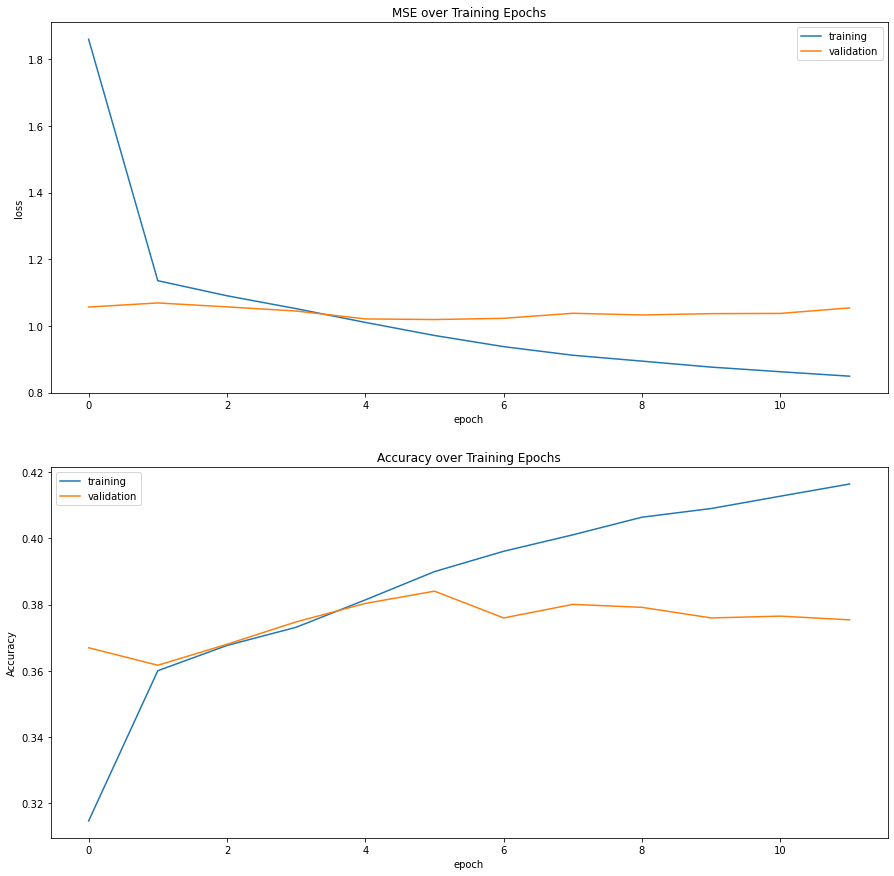

In [13]:
# Print loss history
fig, axs = plt.subplots(2, 1, figsize=(15, 15), squeeze=False)

axs[0][0].plot(loss_history, label='training')
axs[0][0].plot(loss_history_val, label='validation')
axs[0][0].set_xlabel('epoch')
axs[0][0].set_ylabel('loss')
axs[0][0].set_title('MSE over Training Epochs')
axs[0][0].legend()

axs[1][0].plot(accu_history, label='training')
axs[1][0].plot(accu_history_val, label='validation')
axs[1][0].set_xlabel('epoch')
axs[1][0].set_ylabel('Accuracy')
axs[1][0].set_title('Accuracy over Training Epochs')
axs[1][0].legend()

plt.savefig(os.path.join(results_folder, 'LossHistory.png'))
plt.show(block=False)

## Evaluate

In [14]:
checkpoint = torch.load(os.path.join(model_folder, f'best_model.pth'),
                        map_location=torch.device('cpu'))

model = checkpoint['model']
model.to(device)
model.eval()
torch.set_grad_enabled(False)


In [15]:
import pandas as pd

results = []
# test_, test_accu = compute_acc(dataloader_train, model)
# # test_string = f'Test loss: {test_loss}, Test accuracy: {test_accu}'
# test_loss, test_accu = compute_acc(dataloader_val, model)
# # test_string = f'Test loss: {test_loss}, Test accuracy: {test_accu}'
# test_loss, test_accu = compute_acc(dataloader_test, model)
# # test_string = f'Test loss: {test_loss}, Test accuracy: {test_accu}'
# print(test_string)
results.append(list(compute_acc(dataloader_train, model)))
results.append(list(compute_acc(dataloader_val, model)))
results.append(list(compute_acc(dataloader_test, model)))
results_df = pd.DataFrame(results, index = ['train','val','test'], columns = ['loss (MSE)', 'accuracy'])
results_df
results_df.to_csv(os.path.join(results_folder, 'results.csv'))

In [16]:
results_df

,loss (MSE),accuracy
train,0.793157,0.431945
val,1.018937,0.384066
test,0.912326,0.396877


In [17]:
model_folder


'model/mlstm/ml-1m-split/2022-04-09_19h00m17'